<a href="https://colab.research.google.com/github/Yashu2699/Deep_learning/blob/main/Semantic_seg/3d_unet_sm_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd '/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation'

/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation


In [ ]:
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D

In [ ]:
!pip install patchify

In [ ]:
import segmentation_models_3D as sm
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
sm.set_framework('tf.keras')
sm.framework()

In [6]:
image = io.imread('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/train_images_256_256_256.tif')
img_patches = patchify(image, (64,64,64), step=64)

mask = io.imread('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64,64,64), step=64)

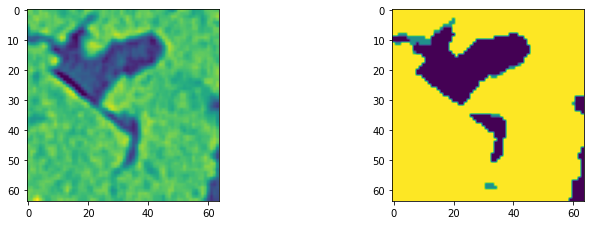

In [10]:
idx = random.randint(1, (img_patches.shape[3]))
plt.figure(figsize=(12,12))
plt.subplot(321)
plt.imshow(img_patches[1,2,3,:,:,idx])
plt.subplot(322)
plt.imshow(mask_patches[1,2,3,:,:,idx])

In [11]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

In [14]:
n_classes = 4

train_img = np.stack((input_img, )*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4)

train_mask_input = to_categorical(train_mask, num_classes=n_classes)

X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_input, test_size=0.10, random_state=0)

In [19]:
backbone = 'vgg16'
encoder_weights = 'imagenet'
patch_size = 64
channels = 3

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [20]:
preprocess_input = sm.get_preprocessing(backbone)

X_train_input = preprocess_input(X_train)
X_test_input = preprocess_input(X_test)

model = sm.Unet(backbone, input_shape=(patch_size, patch_size, patch_size, channels),
                classes=n_classes, activation='softmax',
                encoder_weights=encoder_weights)

model.compile(optimizer, total_loss, metrics)
print(model.summary())

176619520/176605248 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 64, 64, 64,   5248        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv3D)          (None, 64, 64, 64,   110656      ['block1_conv1[0][0]']           
                           

In [ ]:
history = model.fit(X_train_input, y_train, batch_size=8,
                    epochs=100, verbose=1,
                    validation_data=(X_test_input, y_test))

In [22]:
model.save('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/3d_unet.h5')

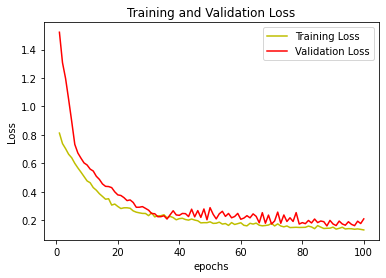

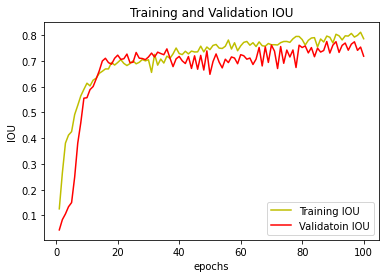

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
plt.plot(epochs, iou, 'y', label='Training IOU')
plt.plot(epochs, val_iou, 'r', label='Validatoin IOU')
plt.xlabel('epochs')
plt.ylabel('IOU')
plt.title('Training and Validation IOU')
plt.legend()
plt.show()

In [29]:
y_pred = model.predict(X_test)
y_pred_arg = np.argmax(y_pred, axis=4)
y_test_arg = np.argmax(y_test, axis=4)  

In [ ]:
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=4)
IOU_keras.update_state(y_test_arg, y_pred_arg)
print(IOU_keras.result().numpy()) 

In [38]:
import random 
idx = random.randint(0, len(X_test))
test_img = X_test[idx]
gt = y_test[idx]
test_img_input = preprocess_input(np.expand_dims(test_img, 0))
test_pred =  model.predict(test_img_input)

In [36]:
test_pred_argmax = np.argmax(test_pred, axis=4)[0,:,:,:]
gt_argmax = np.argmax(gt, axis=3)

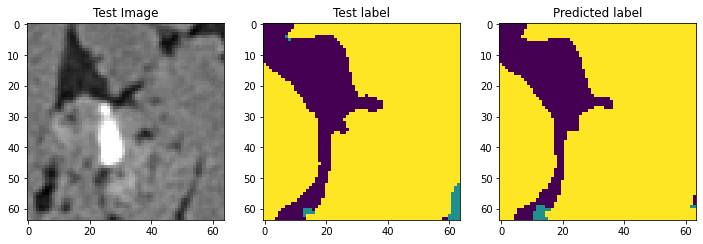

In [42]:
idx = random.randint(0, len(test_img[0]))
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Test Image')
plt.imshow(test_img[idx, :, :, 0], cmap='gray')
plt.subplot(232)
plt.title('Test label')
plt.imshow(gt_argmax[idx, :, :])
plt.subplot(233)
plt.title('Predicted label')
plt.imshow(test_pred_argmax[idx, :, :])
plt.show()